In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"../Shashank/dataset/ImageEmotion (85-15)/train"
test_dir = r"../Shashank/dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [4]:
#preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(
                                   validation_split = 0
                                  )
test_datagen = ImageDataGenerator(validation_split = 0
                                  )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [6]:
emotion_model1 = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')
emotion_model2 = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

preprocess_fn1 = tf.keras.applications.densenet.preprocess_input 
preprocess_fn2 = tf.keras.applications.resnet.preprocess_input 

def emotion_model1_feature_extractor(inputs):
    y = emotion_model1(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def emotion_model2_feature_extractor(inputs):
    y = emotion_model2(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model1, emotion_model2, mainobject_model):
    x, emotion_features1 = emotion_model1(preprocess_fn1(inputs)*1./255)
    x, emotion_features2 = emotion_model2(preprocess_fn2(inputs)*1./255)
    mainobject_features = mainobject_model(preprocess_fn2(inputs)*1./255)
    
    merged_features = tf.concat([mainobject_features, 0.75*emotion_features1, 0.25*emotion_features2], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output, merged_features

def define_compile_model(emotionweights1_path, emotionweights2_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model1 = tf.keras.Model(inputs= inputs, outputs= emotion_model1_feature_extractor(inputs))
    emotion_model1.load_weights(emotionweights1_path)
    emotion_model2 = tf.keras.Model(inputs= inputs, outputs= emotion_model2_feature_extractor(inputs))
    emotion_model2.load_weights(emotionweights2_path)
    mainobject_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output, features = final_model(inputs, emotion_model1, emotion_model2, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= [classification_output, features])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [7]:
emotionweights1_path = r'../Shashank/h5 files/DenseNet201-010-0.780538-0.641440.h5'
emotionweights2_path = r'../Shashank/h5 files/ResNet101-009-0.762864-0.650595.h5'
model = define_compile_model(emotionweights1_path, emotionweights2_path)
model.load_weights(r'h5 files/Idea2_DenseNet201+ResNet101-002-0.783663-0.657614_75-25.h5')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 tf.nn.bias_add (TFOpLambda)    (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_5[0][0]']          

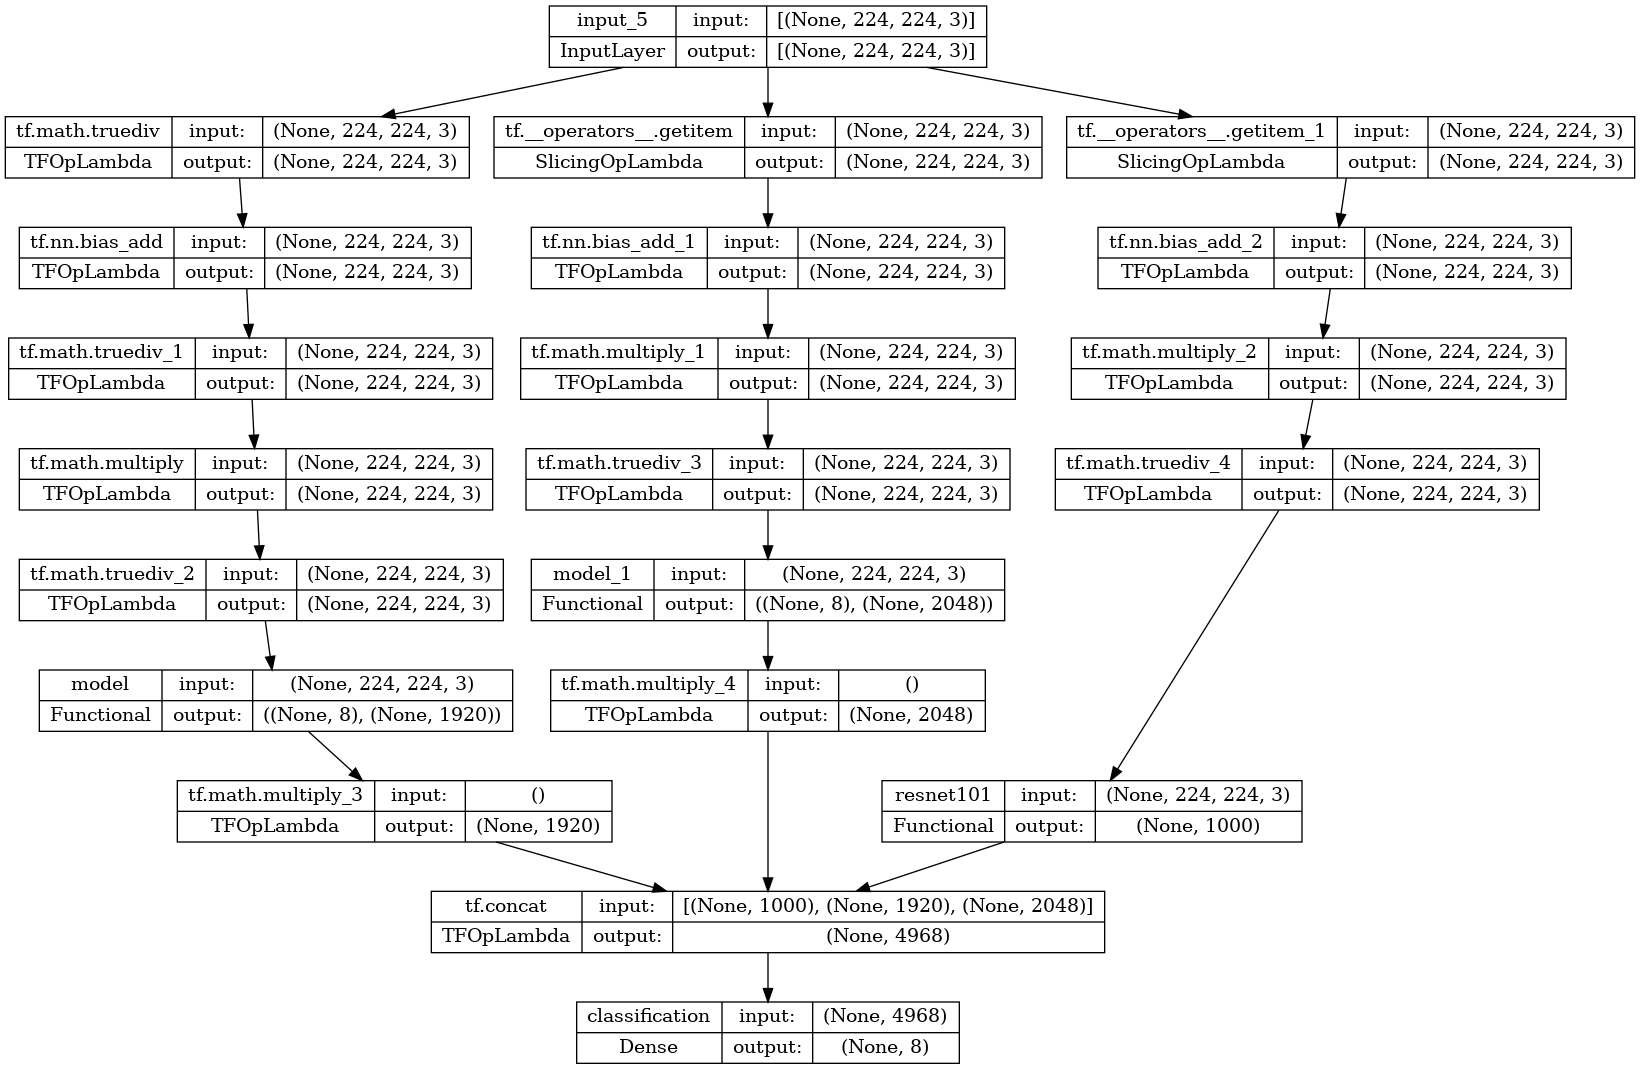

In [8]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [9]:
def feature_extractor(sample_count, generator):
    data = np.zeros(shape=(sample_count, 4968))
    batch_no = 0
    
    while batch_no < (sample_count // BATCH_SIZE) + 1:
        data[batch_no * BATCH_SIZE: (batch_no+1) * BATCH_SIZE] = model(generator[batch_no][0])[-1]
        batch_no += 1
        print(f'Done for batch {batch_no}')
        
    return data

train_data = feature_extractor(18559, train_generator)
print('Done for train.')
test_data = feature_extractor(3277, test_generator)
print('Done for test')

Done for batch 1
Done for batch 2
Done for batch 3
Done for batch 4
Done for batch 5
Done for batch 6
Done for batch 7
Done for batch 8
Done for batch 9
Done for batch 10
Done for batch 11
Done for batch 12
Done for batch 13
Done for batch 14
Done for batch 15
Done for batch 16
Done for batch 17
Done for batch 18
Done for batch 19
Done for batch 20
Done for batch 21
Done for batch 22
Done for batch 23
Done for batch 24
Done for batch 25
Done for batch 26
Done for batch 27
Done for batch 28
Done for batch 29
Done for batch 30
Done for batch 31
Done for batch 32
Done for batch 33
Done for batch 34
Done for batch 35
Done for batch 36
Done for batch 37
Done for batch 38
Done for batch 39
Done for batch 40
Done for batch 41
Done for batch 42
Done for batch 43
Done for batch 44
Done for batch 45
Done for batch 46
Done for batch 47
Done for batch 48
Done for batch 49
Done for batch 50
Done for batch 51
Done for batch 52
Done for batch 53
Done for batch 54
Done for batch 55
Done for batch 56
D

In [10]:
np.save(r'FeatureFiles/EmotionFeatures_train_ResNet101+DenseNet201_25-75.npy', train_data)
np.save(r'FeatureFiles/EmotionFeatures_test_ResNet101+DenseNet201_25-75.npy', test_data)

In [8]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('Idea2_DenseNet201+ResNet101_10-90-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [9]:
#training the model
history = model.fit(train_generator,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_generator,
            callbacks= [checkpoint]
            ) 

history = pd.DataFrame(history.history)

Epoch 1/100
108/290 [==========>...................] - ETA: 34:32 - loss: 1.6220 - acc: 0.4339

KeyboardInterrupt: 

In [9]:
json_model = model.to_json()
with open('Idea2_DenseNet201+ResNet101_10-90.json', 'w') as json_file:
    json_file.write(json_model)
print('Saved model.')

Saved model.
